# BABY training workflow

This notebook provides the steps required to train a new set of models for performing segmentation and bud annotation with the Birth Annotator for Budding Yeast (BABY). It does not provide the steps for training the cell tracking models since these make use of a different data set.

Though relatively long, the notebook provides detailed descriptions of most hyper-parameters and steps so that you can customise training as necessary for your own images and cell types. It is broken up into the following sections:

- [Setting up the Nursery](#Setting-up-the-Nursery): the steps needed to specify the input and target images you want to use for training, and some of the hyper-parameters you can adjust to tweak training.
- [Checking the training inputs and targets](#Checking-the-training-inputs-and-targets): inspect a sample of the augmented data as a sanity check.
- [Training the models](#Training-the-models): the code to actually fit each model.
- [Export trained models for processing](#Export-trained-models-for-processing): export the fitted models as a model set that can be loaded by the `BabyBrain`.
- [Final check that the exported model set works](#Final-check-that-the-exported-model-set-works): visualise segmentation performance of the model set on some test images.

The notebook has been tested on 18-01-2024 with BABY version 0.30.2 (fea5fb61a9c4).

### Bug fix for some GPUs (Optional)

Only run the following code block if you are having issues getting your GPU to work with TensorFlow. The `fix_tf_rtx_gpu_bug` function is a convenience function to set the Tensorflow session up for compatibility with some NVIDIA RTX GPUs (20xx series in my case).

In [ ]:
from baby.training import fix_tf_rtx_gpu_bug
fix_tf_rtx_gpu_bug()

## Setting up the Nursery

Training is coordinated using the `Nursery`. We simply need to specify a directory where all of the settings and models will be saved. The directory needs to exist, but it can be empty. 

For this testing notebook, we first create an empty directory:

In [1]:
from pathlib import Path
save_dir = Path('training-logs/testing-20240118')
assert not save_dir.exists()
save_dir.mkdir(parents=True)

Now we can start a `Nursery` based on that directory.

In [2]:
from baby.training import Nursery
nursery = Nursery('training-logs/testing-20240118')

If you close this notebook at any point, you can normally resume from where you left off by just running the block above to reload the `Nursery`. You should not need to re-run any steps that you have previously run.

### Adding images to the Nursery for training

A fresh `Nursery` starts without images for training, so we need to add some. This is handled by the nursery's `data` property. The `add_from` function takes a folder and searches it recursively for pairs of input/target images. Currently, BABY only supports training images saved in PNG format (i.e., with extension '.png').

Image pairs are identified according to suffix. By default `add_from` looks for image pairs with the same prefix, but with suffix 'brightfield' for the input and suffix 'segoutlines' for the target. For example, 'image_001_brightfield.png' and 'image_001_segoutlines.png' would be considered a pair. If you have different a different suffixes, specify these with the `img_suffix` and `lbl_suffix` args. Once all image pairs in the directory have been identified, the set of pairs is randomly allocated into training, validation and testing sets and this allocation saved to `train_val_pairs.json` in the nursery directory. 

To reuse the same set of images for another nursery, you should copy the `train_val_pairs.json` file into that nursery's directory before adding any more images or running any training steps.

Note that the `add_from` function will only add image pairs from a directory if the nursery does not already have them. That way, if you supplement your training image directory with new images, you can simply add those new images to the nursery by specifying the same base folder. Images will not be included twice and images previously assigned to training/validation/testing sets will remain in their set.

If you want input images to include multiple Z sections, then they should be saved in BABY's tiled PNG format. See the documentation for `baby.io.load_tiled_image` and `baby.io.save_tiled_image` for details.

Target images should be saved using one tile per cell outline. These tiles must be saved according to BABY's tiled PNG format. The meta data of the PNG image should be used to specify which cell outlines should be considered mother-bud pairs. See the documentation for `baby.training.bud_trainer` for details.

The easiest way to generate tiled input and target images is to use the [BABY GUI](https://github.com/julianpietsch/baby-gui) (Graphical User Interface, pronounced GOOEY). This is unfortunately only available via MATLAB. 

Here, we simply add images from a directory containing a subset of the [full training data set](https://doi.org/10.7488/ds/3427) used for the paper.

In [3]:
nursery.data.add_from('training-images/training-testing/')

### Checking how many image pairs and cells are in the training data

You can quickly check how many image pairs are in the training, validation and testing sets by outputting the `data` property. The `ncells` attribute can be used to output how many cells are present (essentially the total number of tiles across all target images).

In [4]:
print(nursery.data)
print(nursery.data.ncells)

TrainValPairs: 32 training, 12 validation and 11 testing pairs
ncells(training=107, validation=42, testing=36)


### Setting training parameters

The training scripts are deliberately flexible and many different parameters can be adjusted from their defaults to tailor the models to a given image processing problem. Often the defaults will work, but the expected inputs and outputs of the model need to be specified. In the following, we also provide recommended tweaks to some of the more important parameters.

Since the training data set here is small, it can be fully loaded into memory. This can be specified via the `in_memory` property of the nursery.

In [5]:
nursery.in_memory = True

#### Default training hyper-parameters

A number of important parameters can be set via the `parameters` property. You can inspect this property to see the available parameters and the defaults that the nursery starts with. 

In [6]:
display(nursery.parameters)

BabyTrainerParameters(train_val_test_pairs_file='train_val_pairs.json', tracker_tvt_pairs_file='tracker_tvt_pairs.json', smoothing_sigma_stats_file='smoothing_sigma_stats.csv', smoothing_sigma_model_file='smoothing_sigma_model.json', flattener_stats_file='flattener_stats.json', flattener_file='flattener.json', segmentation_stats_file='segmentation_stats.csv', segmentation_param_file='segmentation_params.json', mother_bud_props_file='mother_bud_props.csv', mother_bud_model_file='mother_bud_model.pkl', cnn_set=('unet_4s',), cnn_fn=None, batch_size=8, in_memory=True, xy_out=80, target_pixel_size=0.263, substacks=None, aug_probs={}, aug_p_noop=0.05, base_seg_params={}, seg_param_coords={}, input_norm_dw=False, only_basic_augs=True, balanced_sampling=False, use_sample_weights=False, canny_padding=2, n_jobs=4)

#### Updating the training hyper-parameters

The parameters are stored as a named tuple (`baby.training.utils.BabyTrainerParameters`), but can be updated through the `parameters` property of the nursery by assigning to it a `dict` specifying the parameters to update. For example, we can set the size of images output by the augmentation routines by changing the `xy_out` parameter:

In [7]:
nursery.parameters = dict(xy_out=128)

`xy_out` defines the final width and height of images that are input to the neural network during training. If you want width and height to be different, you can specify `xy_out` as a `tuple`, e.g., `xy_out=(128, 96)`.

Note that `xy_out` does not need to match the size of the input images: these will be cropped or padded by the augmentation routines to match. Furthermore, the choice of `xy_out` does not limit input sizes after training- models are reshaped to match image size by the `baby.BabyBrain` when using the models to process data.

Depending on the chosen neural network, the size of the input image may need to be divisible by a power of 2. For example, the default 4-layer U-net includes 3 max pooling operations that halve the width and height of the image each time. So in this case, `xy_out` should be set such that the width and height are a multiple of 8.

The parameters property is also used to set the target number of input Z sections and the pixel size that the model is trained for. These are set by the `substacks` and `target_pixel_size` parameters respectively. The `substacks` parameter specifies the number of Z sections that the augmentation routines should include as input to the neural network. All training images need to include at least this number of Z sections, but if any include more, then they will be sub-sampled. See the docstring of the `baby.augmentation.Augmenter` for more information.

The `target_pixel_size` is used during augmentation to scale the input images to a consistent size. This is important if you are training a model to handle overlapping objects using the BABY algorithm, since overlapping cells are separated by size. The algorithm assumes that small buds, for example, will frequently overlap with their large mother cell, and so can be separately segmented from training targets specialised to these size categories.

The pixel size of the training images can be specified as part of the PNG meta data. See the documentation for `baby.io.load_tiled_image` and `baby.io.save_tiled_image` for more details. If a pixel size is found in the meta data, then the augmentation routine rescales that image to match the `target_pixel_size` for the model we want to train here. Furthermore, if we specify the pixel size of images that we want to process using the `baby.BabyBrain`, then they will also be rescaled to match the pixel size of the trained model.

In [8]:
nursery.parameters = dict(substacks=5, target_pixel_size=0.182)

To increase the effective size of the training data, a number of different augmentations are applied. For a description of these, see the documentation for `baby.augmentation.Augmenter`. By default, each type of augmentation is called with an equal probability such that the probability of no augmentation is 5% (as set by the `aug_p_noop` parameter). We can adjust the probability of individual augmentations via the `aug_probs` parameter. It is recommended to set the probability of vertical or horizontal shifts (translations) to 1 so that large images will not be cropped to the same region. We also recommend increasing the probabilities of the rotation and elastic deformation augmentations. Finally, a number of additional augmentations are recommended that were not included when training models for the our initial publication. These can be included by setting the `only_basic_augs` parameter to `False`.

In [9]:
nursery.parameters = dict(aug_probs=dict(hshift=1, vshift=1, elastic_deform=0.35, rotate=0.35),
                          only_basic_augs=False)

You can also specify multiple different neural network architectures to trial. After training, the model with the best validation result will be selected for subsequent steps. Here, we limit training to the default 4-layer U-net. In our experience, this typically outperforms the other architectures available here.

Parameters of each neural network can also be adjusted by the `hyperparameters` property of the CNN trainer. Here, we increase the width of each convolution block (i.e., the number of features/channels in each block, specified as the kernel size of the convolution operations), by setting the `layer_size` parameter. We also increase the weight for output targets of the CNN that are particularly challenging to predict.

The `use_legacy_adam` parameter is only set here since I am running this on a Macbook with an M1 processor that is not yet compatible with the latest version of the Adam optimiser. 

In [10]:
nursery.parameters = dict(cnn_set=('unet',))
nursery.cnn_trainer.hyperparameters = dict(layer_size=16, use_legacy_adam=True,
                                           weights=dict(lge_edge=2, mid_edge=2, sml_edge=4, sml_inte=2))

Finally, we set the `n_jobs` and `balanced_sampling` parameters. `n_jobs` specifies the target number of processors to use in training routines that have been parallelised.

Setting `balanced_sampling` to `True` means that the the number of times an input image appears during training will vary according to its size. For example, if a training image is four times larger than the average image in the training set, it will appear four times in a given epoch. By setting the probability of translation augmentation to one, as above, this serves to balance the likelihood that each pixel of this image will be seen during training.

In [11]:
nursery.parameters = dict(n_jobs=8, balanced_sampling=True)

### Optimise hyper-parameters for generating the training targets

#### Smoothing model

Augmentation operations like rotation and scaling can produce edge artefacts when applied to bitmask images like our cell mask annotations. The artefacts can be reduced by applying a gaussian filter over the bitmask image before applying the transformation. However, it turns out that the optimal strength (sigma) of the filter depends on the curvature of the edge. 

Here, we optimise the choice of gaussian filter sigma based on the number of edge pixels contained in each outline. We determine the optimal choice by applying symmetric upscaling/downscaling and rotation/unrotation operations on the cell annotations from the training data set, and choose the sigma that minimises the difference between untransformed and transformed images. A function is then fit to this data in order to predict the optimal sigma for a given input cell based on the count of its edge pixels.

The nursery makes available a `fit_smoothing_model` function to automate this process, and we can verify the fit by plotting the fitted smoothing model.

  0%|                                                                                                                                                                                                                          | 0/32 [00:00<?, ?it/s]miniconda3/envs/baby/lib/python3.10/site-packages/imageio/plugins/pillow.py:312: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:06<00:00,  1.90it/s]


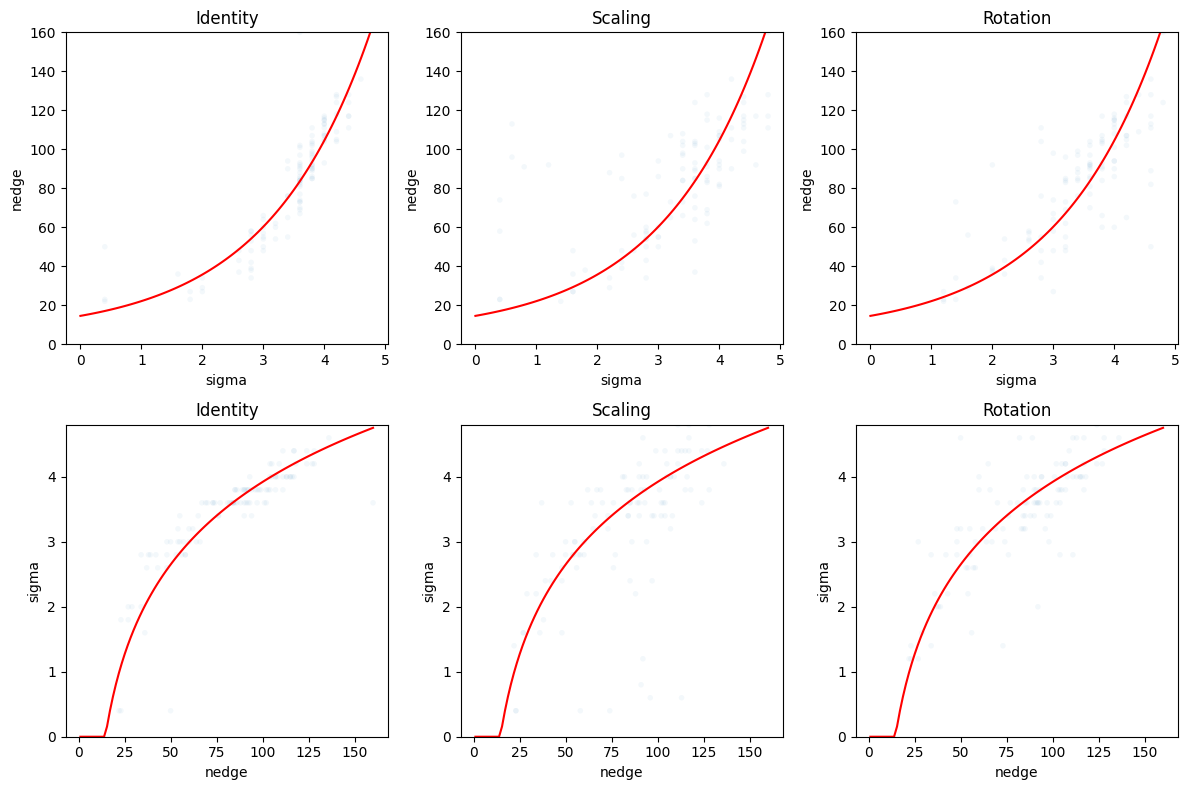

In [12]:
nursery.fit_smoothing_model()
nursery.plot_fitted_smoothing_model()

#### Flattener

The output of a standard U-Net cannot resolve cells that overlap, since these cells will appear merged as one large cell. In order to resolve overlapping cells, the BABY algorithm defines specialised targets for the U-Net that predict cells from different size categories. The algorithm assumes that overlaps occur more frequently between cells from different size categories, as is typical for growth of budding yeast.

To define these targets, the training code takes the cell annotations from the training data and 'flattens' them using a `SegmentationFlattener` object. Since cells can overlap, cell masks are saved and loaded as tiles, one tile per mask. In order to produce a single target image from a variable number of cells, the `SegmentationFlattener` selects cells according to size, optionally applies morphological erosion to each mask, and then takes a logical 'or' operation along the stacked cell axis.

To define the size categories and erosion hyper-parameters, we take the annotated training images and measure mask overlap and cell size between pairs of cells. Size thresholds are then chosen to minimise the frequency of overlap within each size category. The level of erosion for a given size category is limited by specifying the minimum tolerated cell size after erosion for that category (`min_size` argument). It is also limited by ensuring that the median cell size after erosion is higher than some fraction of the median cell size before erosion (`min_size_frac` argument).

As a convenience, additional "bud_neck" and "overlap" targets are specified here via the `bud_max` and `overlaps` arguments. Note that these hyper-parameters are not optimised. The `bud_max` argument specifies the maximum allowed area of cells annotated as buds to be considered for the "bud_neck" target.

Here we also increase the number of thresholds tested (`nbins`) and decrease the size of overlap between neighbouring size categories (`pad_frac`).

In [13]:
nursery.fit_flattener(nbins=101, pad_frac=0.01,
                      min_size=10, min_size_frac=0.5,
                      bud_max=300, overlaps='all')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


You can view the fitted size categories and details for the targets that will be generated via the `flattener` attribute. An interior and edge target are generated for each of the 'small', 'medium' and 'large' size categories (`CellGroup` tuples). Pixels of the generated interior target will be true wherever a cell is present (as defined by its mask after `nerode` rounds of morphological erosion) and not overlapping with any other cells in the size category. Pixels of the generated edge target will be true at the edge of each cell. Examples of the generated targets can be <a href='#Checking-the-training-inputs-and-targets'>found below</a>.

In [14]:
print('Size categories:')
display(nursery.flattener.groupdef)
print('Targets:')
display(nursery.flattener.targets)

Size categories:


{'small': CellGroup(lower=1, upper=102, budonly=False, focus=None),
 'medium': CellGroup(lower=78, upper=363, budonly=False, focus=None),
 'large': CellGroup(lower=339, upper=inf, budonly=False, focus=None),
 'buds': CellGroup(lower=1, upper=300, budonly=True, focus=None),
 'all': CellGroup(lower=1, upper=inf, budonly=False, focus=None)}

Targets:


[PredTarget(name='lge_inte', group='large', prop='interior', nerode=5, ndilate=0, ndilate_overlaps=0, ndilate_mother=2),
 PredTarget(name='lge_edge', group='large', prop='edge', nerode=0, ndilate=0, ndilate_overlaps=0, ndilate_mother=2),
 PredTarget(name='mid_inte', group='medium', prop='interior', nerode=3, ndilate=0, ndilate_overlaps=0, ndilate_mother=2),
 PredTarget(name='mid_edge', group='medium', prop='edge', nerode=0, ndilate=0, ndilate_overlaps=0, ndilate_mother=2),
 PredTarget(name='sml_inte', group='small', prop='filled', nerode=0, ndilate=0, ndilate_overlaps=0, ndilate_mother=2),
 PredTarget(name='sml_edge', group='small', prop='edge', nerode=0, ndilate=0, ndilate_overlaps=0, ndilate_mother=2),
 PredTarget(name='bud_neck', group='buds', prop='budneck', nerode=0, ndilate=0, ndilate_overlaps=0, ndilate_mother=2),
 PredTarget(name='all_ovlp', group='all', prop='overlap', nerode=0, ndilate=0, ndilate_overlaps=0, ndilate_mother=2)]

Finally, you can compare the fitted size categories with plots of the degree of overlap between all pairs of cells. These are shown as heat maps that indicate the level of fractional overlap (the sum over all pairs in a given bin). These are separated according to the size of the larger cell in the pair along the y axis and the smaller cell in the pair along the x axis. Pairs that lie far from the diagonal could potentially be resolved by assignment into different size categories; pairs that lie on the diagonal are similar in size and cannot be resolved by the BABY algorithm. Separate plots are shown for the degree of overlap after all cells have been subjected to `nerosions` rounds of morphological erosion.

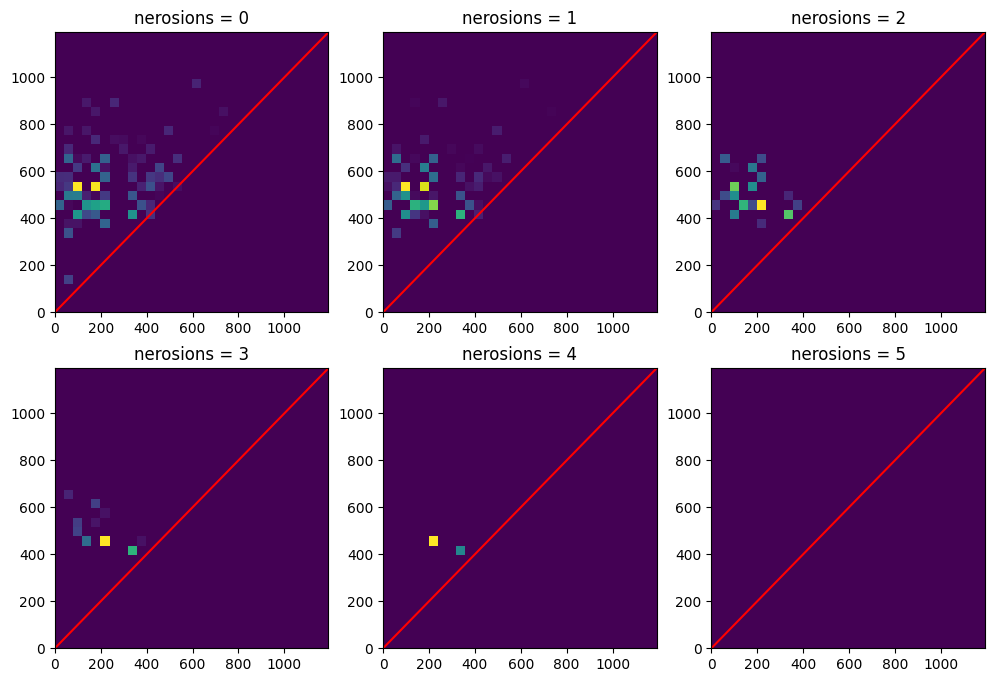

In [15]:
nursery.plot_flattener_stats(nrows=2)

## Checking the training inputs and targets

The inputs and targets for training the models are fed in batches to the training routines by a 'generator'. The nursery includes a separate generator for each of the training, validation and test sets. Here, we run some sanity checks on the training set to make sure that the batches it produces are as expected.

The generators can be accessed via the `gen` attribute of the nursery. Firstly, we can check the shapes of inputs and outputs. The first dimension gives the number of examples per batch, the second and third dimensions are image widths and heights, and the fourth dimension gives the number of Z sections for inputs and number of targets for outputs.

In [16]:
nursery.gen.train.shapes

ImageLabelShapes(input=(8, 128, 128, 5), output=(8, 128, 128, 8))

We can also check which augmentations are included and their probabilities by inspecting the `augmenter` attribute of the generator:

In [17]:
nursery.gen.train.augmenter

<class 'baby.augmentation.ScalingAugmenter'> with augmentation probabilities:
{'substacks': 1.0, 'vshift': 1.0, 'hshift': 1.0, 'rough_crop': 1.0, 'downscale': 1.0, 'shadows': 0.22092219194555585, 'blur': 0.22092219194555585, 'elastic_deform': 0.35, 'rotate': 0.35, 'crop': 1.0, 'vflip': 0.22092219194555585, 'hflip': 0.22092219194555585, 'movestacks': 0.22092219194555585, 'noise': 0.22092219194555585, 'pad': 1.0, 'gamma': 0.22092219194555585, 'hist_deform': 0.22092219194555585, 'hist_scale': 0.22092219194555585}

The training generator can also be used to display a sample batch. The `plot_sample` function displays a training example per column, with rows giving each input section and target for that example. The names of the targets match the names given by the flattener above. Note how morphological erosion of the large interior target ('lge_inte') reduces overlaps within that group (compare with the 'lge_edge' target, which shows cell edges without any erosion).

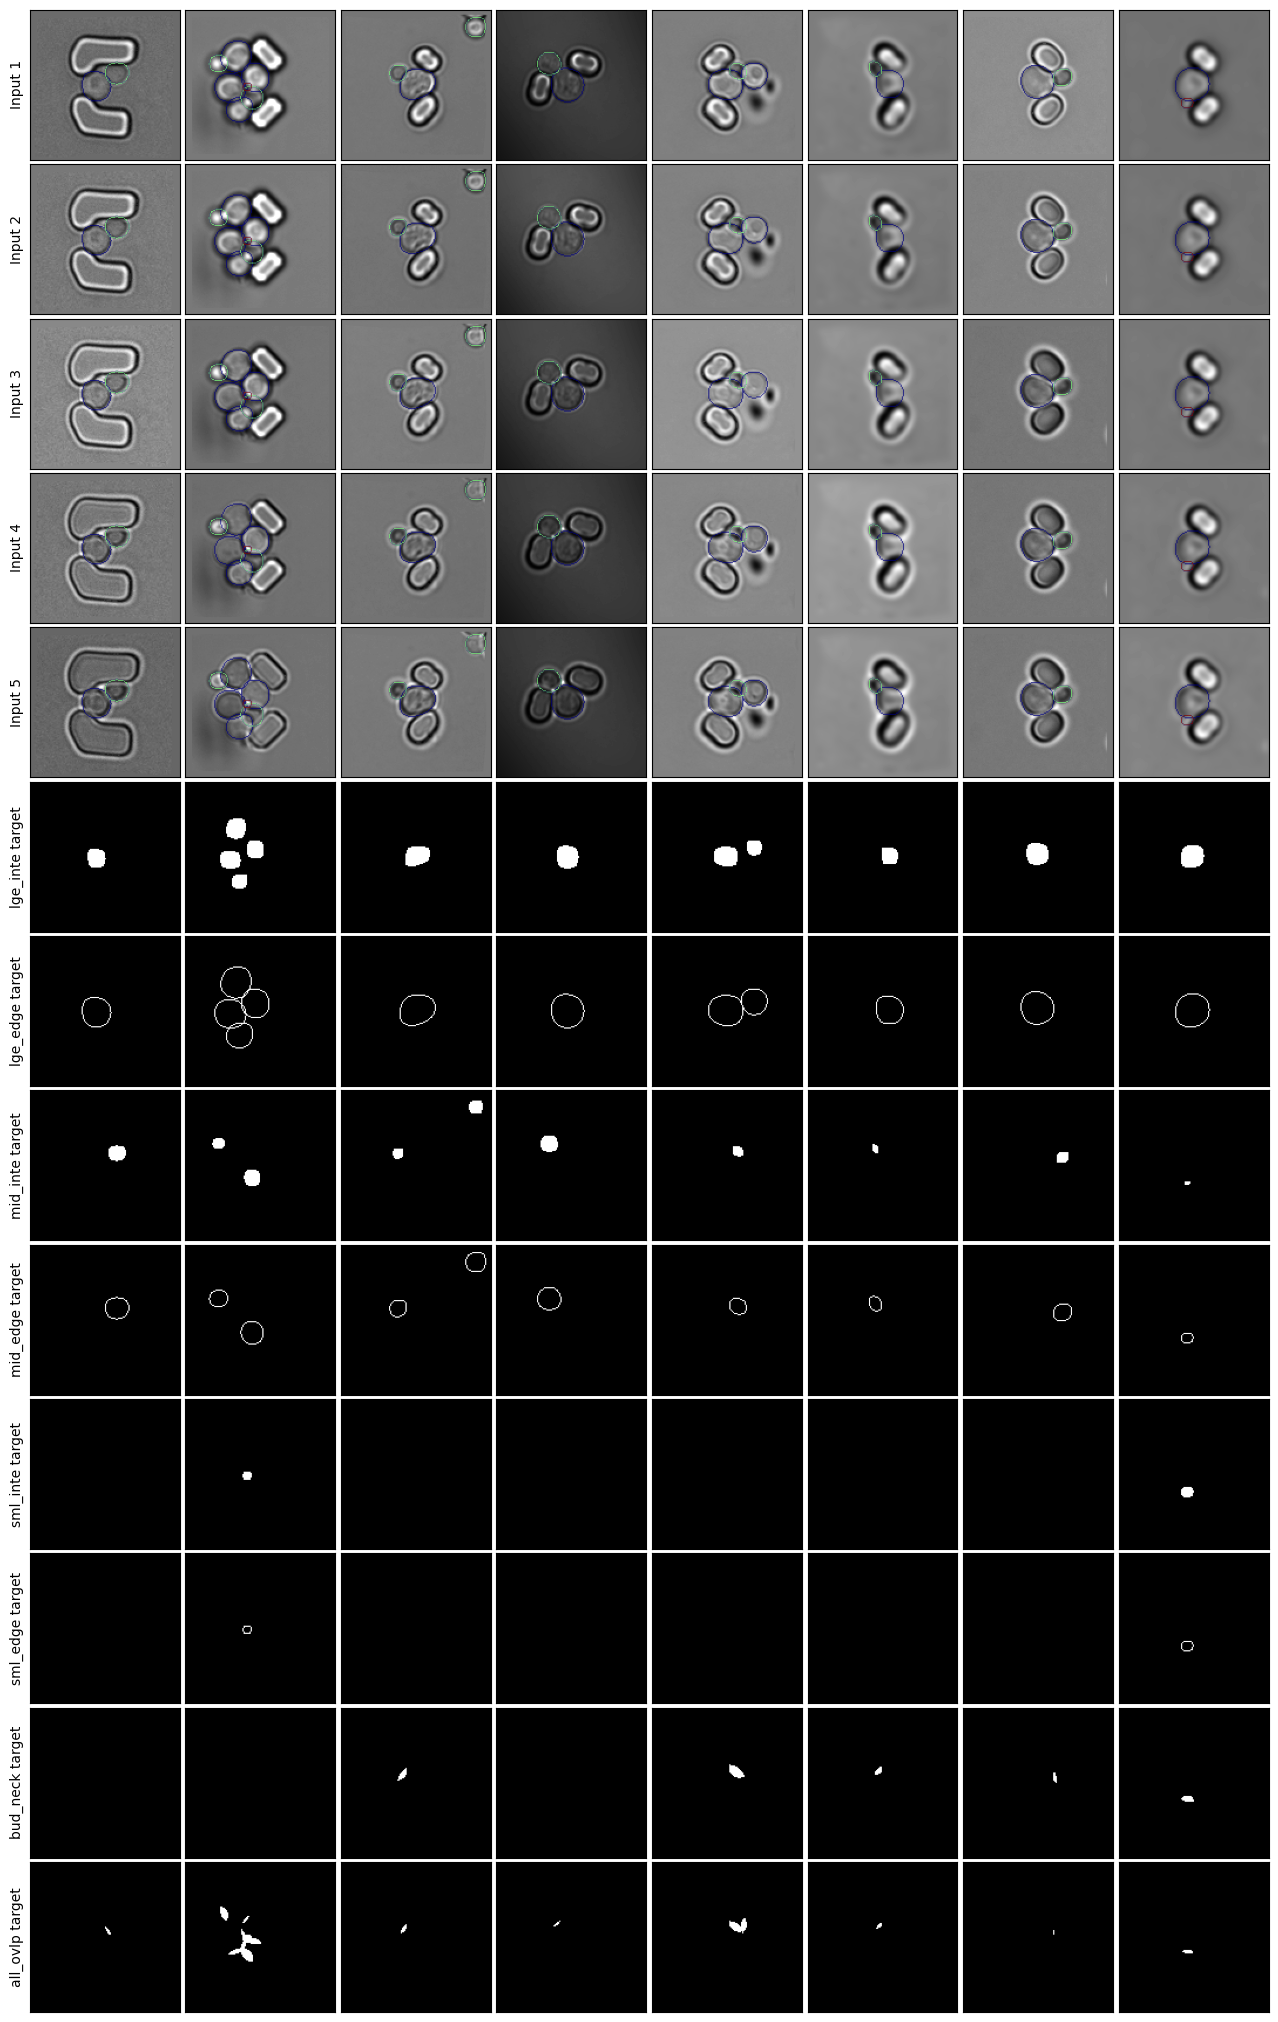

In [18]:
nursery.gen.train.plot_sample(i=0, imgsize=2, show=True)

Finally, we can check the neural network architecture defined when <a href='#Setting-up-the-Nursery'>setting up the nursery</a>. 

Model initialisation is triggered whenever the `cnn` attribute of the `cnn_trainer` is accessed. In the following, we also request a summary of the selected network to see details of all the layers it includes (see the <a href='https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary'>TensorFlow documentation</a> for details of the `summary` method of Keras models).

In [19]:
nursery.cnn_trainer.cnn.summary()

Loading "unet" CNN...


2024-01-18 12:52:40.547713: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-01-18 12:52:40.547737: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-01-18 12:52:40.547747: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-01-18 12:52:40.548020: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-18 12:52:40.548289: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Saving initial weights...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 5)]        0         []                            
                                                                                                  
 enc_conv_1a (Conv2D)        (None, 128, 128, 16)         736       ['input_1[0][0]']             
                                                                                                  
 enc_conv_bn_1a (BatchNorma  (None, 128, 128, 16)         64        ['enc_conv_1a[0][0]']         
 lization)                                                                                        
                                                                                                  
 enc_conv_act_1a (Activatio  (None, 128, 128, 16)         0         

## Training the models

### Training the neural network

The first model that needs to be trained is the neural network, which takes the input images and attempts to predict the training targets defined by the generator. It can be trained using the `fit_cnn` method of the nursery. For this example, we reduce the number of training epochs. Depending on how much training data you have and how quickly the model can fit the data, you may find you need more or less epochs. If more are required, you can specify the additional argument `extend=True` to continue training from the last recorded epoch.

In [ ]:
nursery.fit_cnn(epochs=300)

To check how the training went, we can use the `plot_cnn_histories` method of the nursery. This function plots both training and validation performance as a function of training epoch. The `key` argument specifies which metric to plot. For example, the overall loss can be displayed by setting `key='loss'`; the loss is essentially the 'error' term that the CNN is trying to minimise. The loss due to a given target can be displayed by appending the target name with '_loss', e.g., `key='lge_inte_loss'`. 

However, a more interesting metric for the separate targets is the Dice coefficient. The Dice coefficient is similar to an intersection over union score between predicted and ground truth. It is 1 when the prediction is perfect and 0 when there is no overlap. It can be plotted by appending the target name with '_dice_coeff', e.g., `key='lge_inte_loss'`.

In the following, we display the Dice coefficient for each of the flattener targets and also the overall loss term. Whilst the prediction performance for the large interior target is high and fairly stable by the last epochs, most of the other targets are still showing increasing performance, suggesting that the model would benefit from additional training epochs.

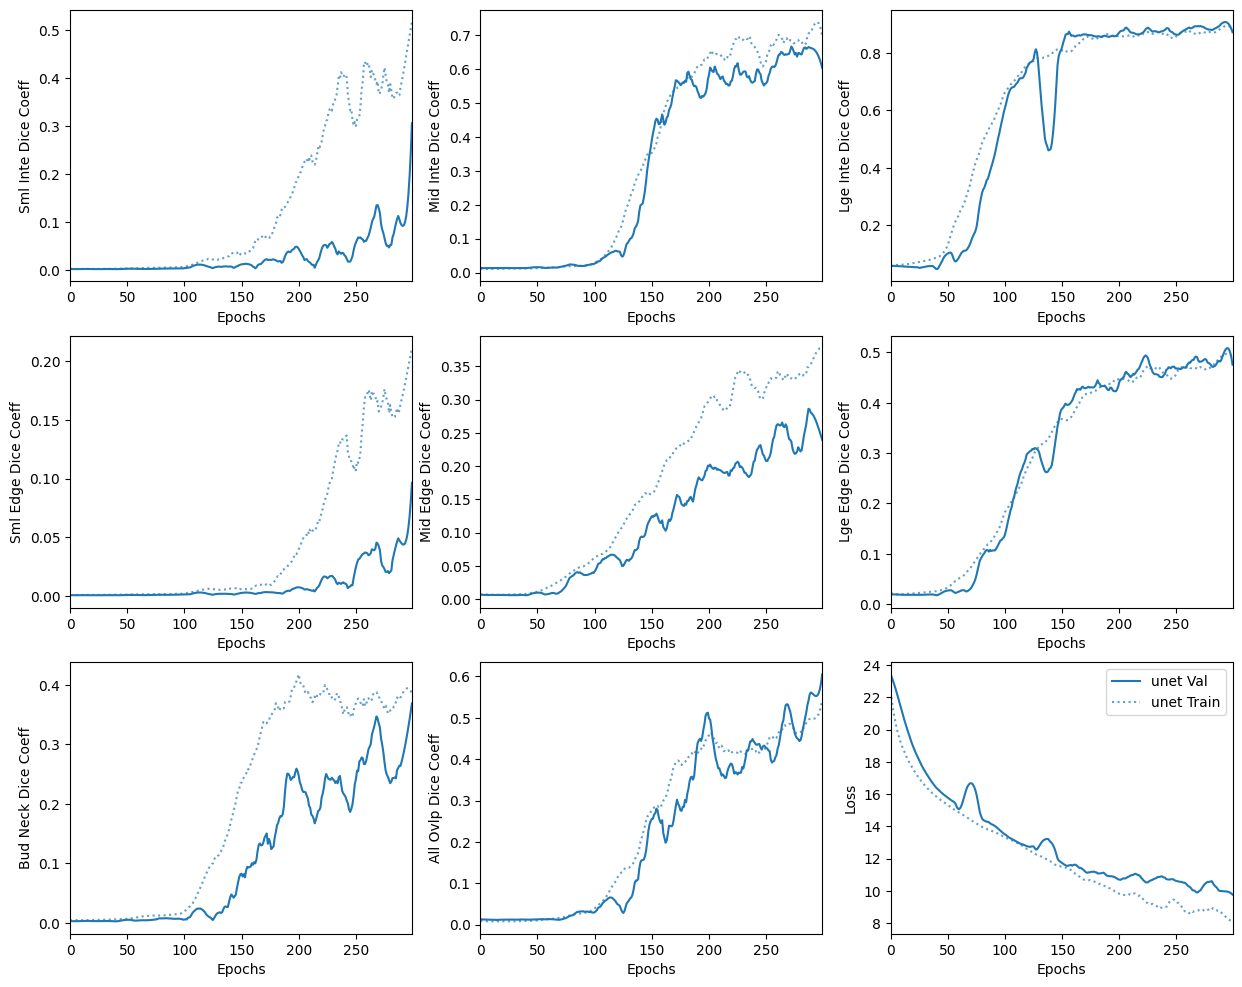

In [21]:
from matplotlib import pyplot as plt
keys = ['sml_inte_dice_coeff', 'mid_inte_dice_coeff', 'lge_inte_dice_coeff',
        'sml_edge_dice_coeff', 'mid_edge_dice_coeff', 'lge_edge_dice_coeff',
        'bud_neck_dice_coeff', 'all_ovlp_dice_coeff', 'loss']
_, axs = plt.subplots(3, 3, figsize=(15, 12))
for ax, key in zip(axs.flatten(), keys):
    nursery.plot_cnn_histories(key=key, log=False, ax=ax, save=False, legend=key == 'loss')

### Training the bud assignment model

Once the neural network has been trained and we are happy with its performance, we can train the bud assignment model that makes use of the `bud_neck` target and a few other cell shape metrics to predict assignments between mother cells and their buds. We first generate a table of features from the training masks and CNN outputs for each pair of cells, and then simply call the `fit` method: 

In [ ]:
nursery.bud_trainer.generate_property_table()
nursery.bud_trainer.fit()

Once trained, we can check the precision-recall curve for our model:

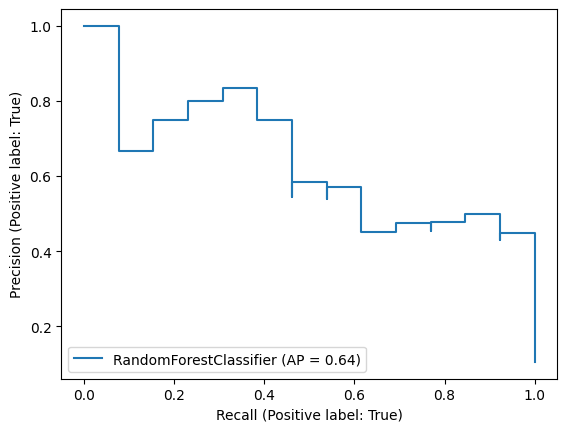

In [23]:
nursery.bud_trainer.plot_PR()

Various performance metrics for the model on the training, validation and test sets can be displayed as follows:

In [24]:
nursery.bud_trainer.performance()

TrainValTestProperty(train=Score(accuracy=0.8603896103896104, balanced_accuracy=0.8299220272904484, precision=0.46153846153846156, recall=0.7894736842105263, F1=0.5825242718446603, F0_5=0.5033557046979866, F2=0.6912442396313365), val=Score(accuracy=0.8709677419354839, balanced_accuracy=0.927927927927928, precision=0.4482758620689655, recall=1.0, F1=0.6190476190476191, F0_5=0.5038759689922481, F2=0.802469135802469), test=Score(accuracy=0.8723404255319149, balanced_accuracy=0.9302325581395349, precision=0.4, recall=1.0, F1=0.5714285714285715, F0_5=0.45454545454545453, F2=0.7692307692307692))

Finally, the importance of each feature in the trained model can also be inspected:

In [25]:
nursery.bud_trainer.feature_importance

{'p_bud_mat': 0.10308729612559663,
 'size_ratio_mat': 0.42583527678944955,
 'p_budneck_mat': 0.0745272192640135,
 'budneck_ratio_mat': 0.13453282572499045,
 'adjacency_mat': 0.26201738209594994}

### Optimising segmentation parameters

The output of the CNN itself does not segment the image into distinct cells. The BABY algorithm instead uses the output of the CNN to (1) detect cells, (2) filter out cells of the wrong size, (3) exclude the same cell detected in multiple size categories, and (4) refine cell outlines according to the edge targets of the CNN.

Each of these steps includes a number of different hyper-parameters that we optimise here on the validation data using the `segmentation_trainer`. We choose to favour recall over precision by scoring according to the 'F2' metric.

In [26]:
nursery.segmentation_trainer.fit_seg_params(scoring='F2')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 756/756 [03:43<00:00,  3.39it/s]


Once the segmentation parameters have been optimised, we can assess final segmentation performance of the algorithm on the training, validation and test sets using the `validate_seg_params` method.

For each training example, this method finds the best match between predicted and ground-truth masks and then calculates the intersection over union (IoU) score for matching pairs. The mean and minimum IoU over all matching pairs for each example are recorded. 

To assess precision and recall, the method also calculates the average precision over each training example. Here, the average precision (AP) is the area under the (step-wise monotonic) precision-recall curve for a given example. For this calculation, cell masks are first ordered by the 'edge score', the mean value of edge pixels of the segmented mask on the edge targets of the CNN. Precision and recall are then calculated (assuming true positives when $IoU > 0.5$) by sequential addition of segmented masks to the test set in order of decreasing edge score. The AP is the area under the resulting precision-recall curve after it has been made monotonic decreasing.

The printed output shows, for each data set, the means over all training examples of the mean and minimum IoU and the AP. The histograms show how these are distributed.

In [27]:
nursery.segmentation_trainer.validate_seg_params()

{'train': IoU_mean    0.835039
IoU_min     0.610544
AP          0.891592
dtype: float64, 'val': IoU_mean    0.788505
IoU_min     0.522086
AP          0.816468
dtype: float64, 'test': IoU_mean    0.780269
IoU_min     0.470911
AP          0.848485
dtype: float64}


We can also inspect the optimised segmentation hyper-parameters via the `segmentation_parameters` attribute of the nursery.

In [28]:
nursery.segmentation_parameters

SegmentationParameters(cellgroups=None, edge_sub_dilations=[2, 1, 0], interior_threshold=[0.49999999999999994, 0.44999999999999996, 0.3], nclosing=[0, 0, 0], nopening=[0, 0, 0], connectivity=[1, 2, 1], min_area=9, fit_radial=True, cartesian_spline=False, bbox_padding=[10, 10, 10], nrays_thresh_map=[(5.0, 4), (20.0, 6)], nrays_max=8, n_trials=10, pxperknot=4.0, squishiness=0.1, alignedness=10.0, curvy_knots=False, n_knots_fraction=0.5, pedge_thresh=[0.0, 0.0, 0.0], use_group_thresh=True, group_thresh_expansion=[0.0, 0.4, 0.0], containment_func='mask_containment', containment_thresh=0.8)

**NB:** Many of the parameters listed above are *not* optimised and should instead be configured manually *before* optimising hyper-parameters using the `fit_seg_params` method. For example, if the objects you are segmenting are not normally ellipsoid (e.g., they are rod-shaped like *E. coli*), then segmentation should proceed with a cartesian rather than radial spline (`cartesian_spline=True`). If your cells have particularly complicated morphology, you may also wish to increase the number of knots (rays) by adjusting the `nrays_thresh_map` and `nrays_max` parameters. 

The parameters that are optimised by `fit_seg_params` include the `interior_threshold`, `nclosing`, `nopening`, `connectivity`, `min_area`, `pedge_thresh`, `group_thresh_expansion` and `containment_thresh`.

Detailed descriptions of all segmentation parameters can be found in the doc string for the `baby.morph_thresh_seg.SegmentationParameters` tuple.

## Export trained models for processing

Once you have run all the training steps above, the models and configuration can be saved to your local cache of model sets so that they can be accessed by both the `BabyBrain` and the BABY server (i.e., `baby-phone`).

First, we specify a training date and unique name for this model set. The following code uses these to create a folder in the local model sets cache (the `modelset_path`) and to annotate each of the model files with the date of training. We then copy each of the model files to the `modelset_path` and keep a record of the file names used (`target_filenames`) to help with model set specification in the next code block.

In [29]:
import shutil
from baby.modelsets import LOCAL_MODELSETS_PATH

# Define a training date and a name for the model set.
# We will use these below to create the model set directory 
# and ensure unique file names for the models.
training_date = '20240118'
modelset_name = 'example-modelset-yeast-alcatras-brightfield-EMCCD-60x-5z'

# Create a directory for this model set in the local cache
modelset_path = LOCAL_MODELSETS_PATH / modelset_name
modelset_path.mkdir(parents=True, exist_ok=True)

# Copy relevant model files to the local cache
files_to_copy = {
    'flattener': nursery.flattener_trainer.flattener_file,
    'cnn': nursery.cnn_trainer.opt_cnn_file,
    'segparams': nursery.segmentation_trainer.segment_parameters_file,
    'budassign': nursery.bud_trainer.model_save_file
}
target_filenames = {}
for target_name, src_path in files_to_copy.items():
    target_filename = f'{training_date}_{target_name}{src_path.suffix}'
    target_filenames[target_name] = target_filename
    shutil.copyfile(src_path, modelset_path / target_filename)

To complete the model set specification, we next specify both meta-data and the arguments required to instantiate a `BabyBrain` for this model set. This gets saved to a `modelset.json` file in the `modelset_path`.

There are no restrictions on the data you can include in the `'meta'` dict. However, it is recommended that you include at least the fields in this example, as they can help with model filtering in packages like the [BABY-GUI](https://github.com/julianpietsch/baby-gui).

The contents of the `'brain_params'` dict are passed directly to the `BabyBrain` constructor. For details of the arguments, see the `baby.BabyBrain` docstring. Here, we decrease the `'isbud_thresh'` so that fewer buds are rejected during bud assignment. We also specify the default shared cell tracking models. These will typically work well for cells with similar morphology to yeast.

In [30]:
# Specify meta-data and arguments to the BabyBrain for this model set
modelset_spec = {
    'name': modelset_name,
    'meta': {
        'species': 'yeast',
        'device': 'alcatras',
        'channel': 'brightfield',
        'camera': 'sCMOS',
        'optical_zoom': 60,
        'z_sections': nursery.parameters.substacks,
        'pixel_size': nursery.parameters.target_pixel_size
    },
    'brain_params': {
        'morph_model_file': target_filenames['cnn'],
        'flattener_file': target_filenames['flattener'],
        'params': target_filenames['segparams'],
        'budassign_model_file': target_filenames['budassign'],
        'pixel_size': nursery.parameters.target_pixel_size,
        'celltrack_model_file': 'ct_rf_20210201_12.pkl',
        'celltrack_backup_model_file': 'ct_rf_20210125_9.pkl',
        'default_image_size': [117, 117],
        'isbud_thresh': 0.35
    }
}

import json
with open(modelset_path / 'modelset.json', 'wt') as f:
    json.dump(modelset_spec, f, indent=2)

## Final check that the exported model set works

Once the model set has been made available, we check here that it can be loaded and use it to segment some of the images from the nursery's test set. We also overlay the segmented outlines on the input bright-field images for a visual assessment of performance.

miniconda3/envs/baby/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
miniconda3/envs/baby/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/var/folders/n5/h4w3yrl17px0v17l6vmyvrf00000gp/T/ipykernel_39506/1182944092.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


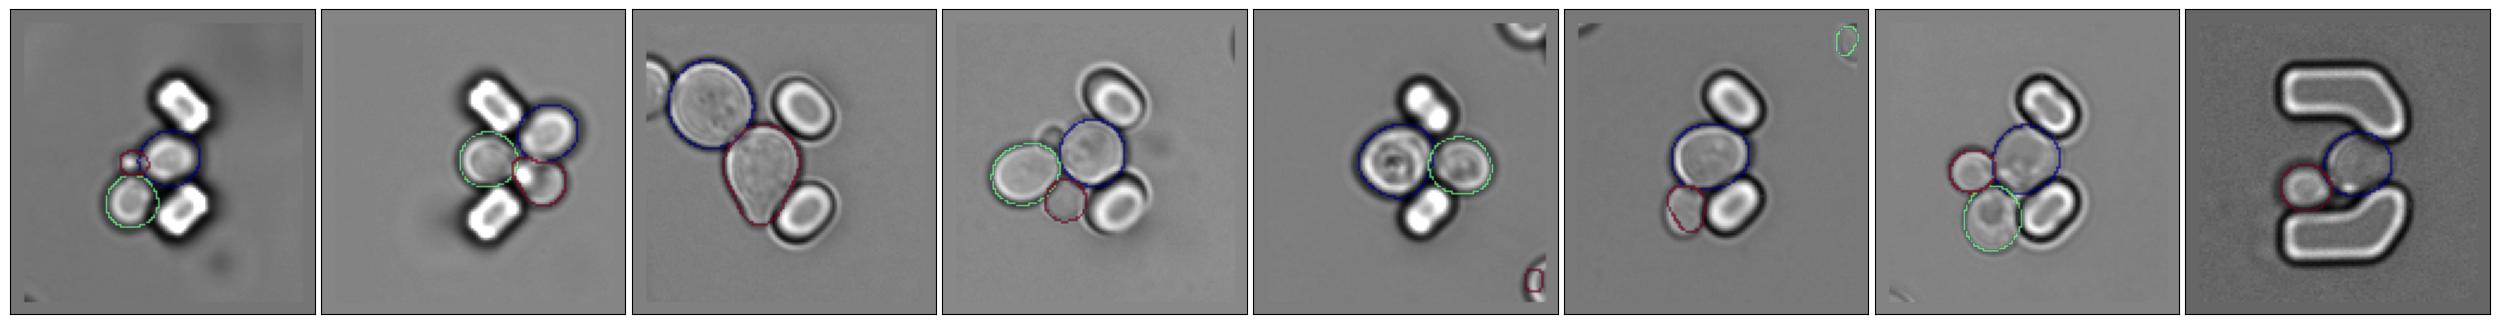

In [31]:
# Get the BabyBrain for our new model set
from baby import modelsets
brain = modelsets.get(modelset_name)

# Collect the first batch of bright-field inputs from the generator for the
# test set
inputs, _ = nursery.gen.test[0]

# Use the brain to segment the bright-field images and return bitmasks for
# the cell edges
segmented = brain.segment(inputs, refine_outlines=True, yield_edgemasks=True)

# Display the segmentation results overlaid on the first Z section
from baby.visualise import plot_ims, colour_segstack
fig, axs = plot_ims(inputs[..., 0], show=False)
for ax, seg in zip(axs, segmented):
    outlines = seg['edgemasks']
    ax.imshow(colour_segstack(outlines))
fig.show()